<a href="https://colab.research.google.com/github/ryannnchang/SVM-HAR/blob/main/RCHARModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Binary Classification Model in Machine Learning Using SciKit-Learn
### Ryan Chang | June 26, 2025 | Biomedic.AI Lab


In this google colab, I will creating a SVM binary classification model attempts predicts the difference between walking and non-walking.

The dataset used is the from the UCI HAR dataset. https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones




#Getting data from HAR dataset
Using only the total acceleration signals

In [196]:
##Getting data from UCI HAR dataset

import numpy as np
from google.colab import files
from google.colab import drive
import pandas as pd

total_acc_x_test = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt")
total_acc_y_test = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt")
total_acc_z_test = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt")

total_acc_x_train = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt")
total_acc_y_train = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt")
total_acc_z_train = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt")

y_test = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/test/y_test.txt")
y_train = np.loadtxt("/content/drive/MyDrive/HAR Dataset/UCI HAR Dataset/train/y_train.txt")

y_test -= 1
y_train -= 1

X_test = np.concatenate((total_acc_x_test, total_acc_y_test, total_acc_z_test), axis=1)
print(X_test.shape)


(2947, 384)


## Converting HAR dataset into walking and non-walking
HAR dataset contains 6 classes, however for this project I will only be detecting whether the person is walking or not

In [197]:
##Counting how many classes there are in test and train
unique, counts = np.unique(y_test, return_counts=True)
unique2, counts2 = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))
print(dict(zip(unique2, counts2)))

{np.float64(0.0): np.int64(496), np.float64(1.0): np.int64(471), np.float64(2.0): np.int64(420), np.float64(3.0): np.int64(491), np.float64(4.0): np.int64(532), np.float64(5.0): np.int64(537)}
{np.float64(0.0): np.int64(1226), np.float64(1.0): np.int64(1073), np.float64(2.0): np.int64(986), np.float64(3.0): np.int64(1286), np.float64(4.0): np.int64(1374), np.float64(5.0): np.int64(1407)}


In [198]:
## Changing anything that is not into a one
for i in range(len(y_train)):
  if y_train[i] != 0.0:
    y_train[i] = 1.0

for i in range(len(y_test)):
  if y_test[i] != 0.0:
    y_test[i] = 1.0

In [199]:
##Recounting Data
unique1, counts1 = np.unique(y_test, return_counts=True)
unique2, counts2 = np.unique(y_train, return_counts=True)

print("Test Data", dict(zip(unique1, counts1)))
print("Train Data",dict(zip(unique2, counts2)))

Test Data {np.float64(0.0): np.int64(496), np.float64(1.0): np.int64(2451)}
Train Data {np.float64(0.0): np.int64(1226), np.float64(1.0): np.int64(6126)}


##Balancing the Dataset

In [200]:
##Balancing the train dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

flatten_X = np.concatenate((total_acc_x_train, total_acc_y_train, total_acc_z_train), axis=1)

X_resampled, y_resampled = rus.fit_resample(flatten_X, y_train)
X_train = X_resampled

In [201]:
unique2, counts2 = np.unique(y_resampled, return_counts=True)

print(dict(zip(unique2, counts2)))

{np.float64(0.0): np.int64(1226), np.float64(1.0): np.int64(1226)}


## Creating the Model V1

In [202]:
#Importing SMV using Scikit learn built-in library
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#Getting SMV from SciKit learn
svc=SVC()
svc.fit(X_train,y_resampled)
y_pred=svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Model accuracy score with default hyperparameters: 0.5772


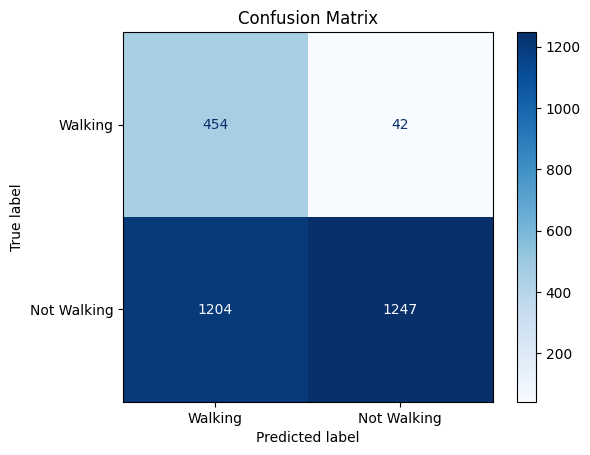

In [203]:
#Generating Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

class_names = ['Walking', 'Not Walking']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Feature extraction
Flattening the windows and inputting them into the SVC did not work that well. I did some research and looked more into feature extraction. Based on UCI HAR article about the dataset, they provided

In [204]:
## Changing the data - Assigning features to Time Series data
import numpy as np
from scipy.stats import entropy

X_train3D = np.reshape(X_train, (-1, 3, 128))
X_train3D.shape

features = []

for i in range(len(X_train3D)):
  #Mean
  mean_x = np.mean(X_train3D[i][0])
  mean_y = np.mean(X_train3D[i][1])
  mean_z = np.mean(X_train3D[i][2])

  #Standard deviation
  std_x = np.std(X_train3D[i][0])
  std_y = np.std(X_train3D[i][1])
  std_z = np.std(X_train3D[i][2])

  #Max
  max_x = np.max(X_train3D[i][0])
  max_y = np.max(X_train3D[i][1])
  max_z = np.max(X_train3D[i][2])

  #Min
  min_x = np.min(X_train3D[i][0])
  min_y = np.min(X_train3D[i][1])
  min_z = np.min(X_train3D[i][2])

  #average of squazes
  square_x = np.mean(np.square(X_train3D[i][0]))
  square_y = np.mean(np.square(X_train3D[i][1]))
  square_z = np.mean(np.square(X_train3D[i][2]))

  #correlation coeffient
  corr_xy = np.corrcoef(X_train3D[i][0], X_train3D[i][1])[0][1]
  corr_xz = np.corrcoef(X_train3D[i][0], X_train3D[i][2])[0][1]
  corr_yz = np.corrcoef(X_train3D[i][1], X_train3D[i][2])[0][1]

  features.append([mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, square_x, square_y, square_z, corr_xy, corr_xz, corr_yz])

features_train = np.array(features)
features_train.shape, X_train3D.shape, y_resampled.shape

((2452, 18), (2452, 3, 128), (2452,))

In [205]:
##Changing testing Data
features_test = []
X_test3D = np.stack((total_acc_x_test, total_acc_y_test, total_acc_z_test), axis=1)

for i in range(len(X_test3D)):
  #Mean
  mean_x = np.mean(X_test3D[i][0])
  mean_y = np.mean(X_test3D[i][1])
  mean_z = np.mean(X_test3D[i][2])

  #Standard deviation
  std_x = np.std(X_test3D[i][0])
  std_y = np.std(X_test3D[i][1])
  std_z = np.std(X_test3D[i][2])

  #Max
  max_x = np.max(X_test3D[i][0])
  max_y = np.max(X_test3D[i][1])
  max_z = np.max(X_test3D[i][2])

  #Min
  min_x = np.min(X_test3D[i][0])
  min_y = np.min(X_test3D[i][1])
  min_z = np.min(X_test3D[i][2])

  #average of squares
  square_x = np.mean(np.square(X_test3D[i][0]))
  square_y = np.mean(np.square(X_test3D[i][1]))
  square_z = np.mean(np.square(X_test3D[i][2]))

  #correlation coefficient
  corr_xy = np.corrcoef(X_test3D[i][0], X_test3D[i][1])[0][1]
  corr_xz = np.corrcoef(X_test3D[i][0], X_test3D[i][2])[0][1]
  corr_yz = np.corrcoef(X_test3D[i][1], X_test3D[i][2])[0][1]

  features_test.append([mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, square_x, square_y, square_z, corr_xy, corr_xz, corr_yz])

features_test = np.array(features_test)
features_test.shape, X_test3D.shape, y_test.shape



((2947, 18), (2947, 3, 128), (2947,))

##Creating Model V2 using 18 features extracted

In [232]:
#Importing SMV using Scikit learn built-in library
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#Getting SMV from SciKit learn
svcv2=SVC(kernel='rbf', C=252)
svcv2.fit(features, y_resampled)
y_pred2 = svcv2.predict(features_test)

print('Model accuracy score with 18 selected features: {0:0.4f}'. format(accuracy_score(y_test, y_pred2)))

Model accuracy score with 18 selected features: 0.9308


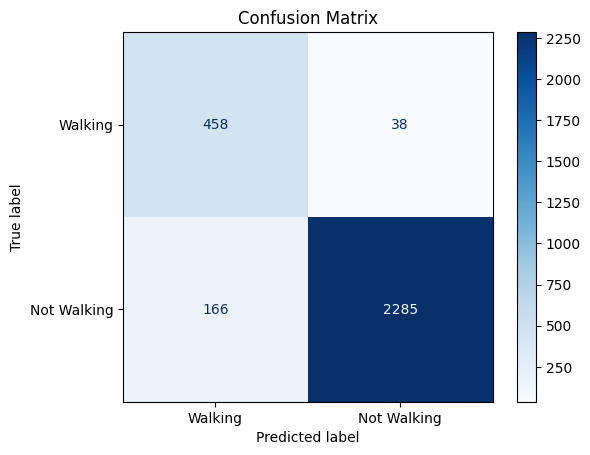

In [233]:
#Generating Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred2)

class_names = ['Walking', 'Not Walking']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()